In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u 
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA
from asteria.simulation import Simulation

from snewpy.neutrino import Flavor
from snewpy.models.ccsn import Sukhbold_2015, Nakazato_2013
mpl.rc('font', size=20)
%matplotlib inline

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


In [2]:
# this function loads the model and runs ASTERIAs simulation, it returns the time sequence, signal and background
# as well as the model name

def model_sig_bkg(model_name, dt):
    if model_name == "Sukhbold_2015_27_LS220":
        model = {'name': 'Sukhbold_2015',
                 'param':{'progenitor_mass': 27*u.Msun, 'eos': 'LS220'}}
    elif model_name == "Sukhbold_2015_27_SFHo":
        model = {'name': 'Sukhbold_2015',
                 'param':{'progenitor_mass': 27*u.Msun, 'eos': 'SFHo'}}
    elif model_name == "Sukhbold_2015_9_LS220":
        model = {'name': 'Sukhbold_2015',
                 'param':{'progenitor_mass': 9.6*u.Msun, 'eos': 'LS220'}}
    elif model_name == "Sukhbold_2015_9_SFHo":
        model = {'name': 'Sukhbold_2015',
                 'param':{'progenitor_mass': 9.6*u.Msun, 'eos': 'SFHo'}}
    elif model_name == "Nakazato_2013_20_100ms_0.02_shen":
        model = {'name': 'Nakazato_2013',
                 'param':{'progenitor_mass': 20*u.Msun, 'revival_time': 100*u.ms, 'metallicity': 0.02, 
                          'eos': 'shen'}}
    elif model_name == "Nakazato_2013_50_300ms_0.004_shen":
        model = {'name': 'Nakazato_2013',
                 'param':{'progenitor_mass': 50*u.Msun, 'revival_time': 300*u.ms, 'metallicity': 0.004, 
                          'eos': 'shen'}}
        
    sim = Simulation(model=model,
             distance=10* u.kpc, 
             Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
             tmin=-0.05*u.s, tmax=20.0*u.s, dt=0.1*u.ms,        
             #tmin=-0.35*u.s, tmax=15.44*u.s, dt=0.1*u.ms,
             hierarchy = 'normal',
             mixing_scheme = 'NoTransformation',
             geomscope = 'IC86',
             include_wls = False)
    sim.run()

    t, sig = sim.detector_hits(dt=dt)
    bkg = sim.detector.dc_bg(dt=dt, size = len(sig)) + sim.detector.i3_bg(dt=dt, size = len(sig))
    
    return t, sig, bkg, model

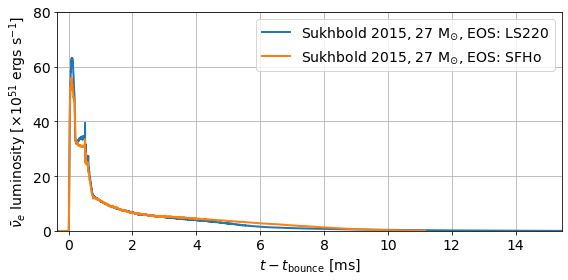

In [4]:
# plots the luminosity
m27_ls220 = Sukhbold_2015(progenitor_mass=27*u.solMass, eos='LS220')
m27_sfho = Sukhbold_2015(progenitor_mass=27*u.solMass, eos='SFHo')

models = [m27_ls220, m27_sfho]

flavor = Flavor.NU_E_BAR
fig, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=True, sharey=True, tight_layout=True)
for j, model in enumerate(models):
    ax.plot(model.time, model.luminosity[flavor]/1e51,  # Report luminosity in units ergs/s
            label = 'Sukhbold 2015, 27 M$_{{\odot}}$, EOS: LS220' if j == 0 
            else 'Sukhbold 2015, 27 M$_{{\odot}}$, EOS: SFHo',
            lw=2)
ax.set(xlim=(-0.35, 15.44), ylim=(0.0, 80.0))
ax.tick_params(labelsize=14)
ax.grid()
ax.legend(fontsize = 14)
ax.set_xlabel(r'$t-t_{\rm bounce}$ [ms]', fontsize=14)
ax.set_ylabel(r'$\bar{\nu}_e$ luminosity [$\times 10^{51}$ ergs s$^{-1}$]', fontsize=14)
plt.tight_layout()

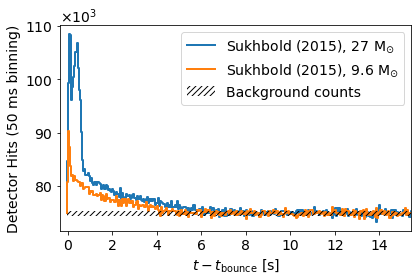

In [8]:
# plots the detector hit rate for the Sukhbold model
models = ["Sukhbold_2015_27_LS220","Sukhbold_2015_9_LS220"]
dt = 50*u.ms
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, tight_layout=True)

for j, model in enumerate(models):
    t, sig, bkg, m = model_sig_bkg(model, dt=dt)
    ax.step(t, sig+bkg, label = "Sukhbold (2015), 27 M$_{{\odot}}$" if j == 0 else "Sukhbold (2015), 9.6 M$_{{\odot}}$", lw=2, zorder = j)
    # label = m['name'] + ', {} M$_{{\odot}}$, EOS: '.format(m['param']['progenitor_mass'].value) + m['param']['eos']

ax.fill_between(t.value, bkg.mean()-bkg.std(), bkg.mean()+bkg.std(), hatch = r"////", linewidth = 0, 
                facecolor= 'none', edgecolor = 'k', label = 'Background counts', zorder = 10)
ax.set(xlim=(-0.35, 15.44))

# change y ticks to show a x 10^b
ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3), useOffset=False, useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.tick_params(labelsize=14)

#ax.grid()
ax.legend(fontsize = 14)
ax.set_xlabel(r'$t-t_{\rm bounce}$ [s]', fontsize=14)
ax.set_ylabel('Detector Hits (50 ms binning)', fontsize=14)
plt.tight_layout()
plt.savefig('Sukhbold_Nora.png', dpi = 200, facecolor = 'white')

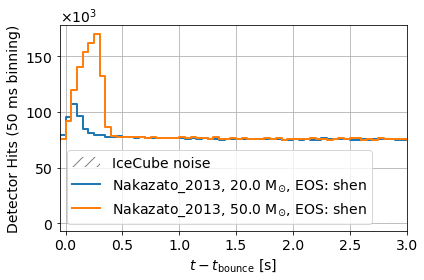

In [146]:
models = ["Nakazato_2013_20_100ms_0.02_shen","Nakazato_2013_50_300ms_0.004_shen"]
dt = 50*u.ms
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, tight_layout=True)

ax.fill_between(t.value, bkg.mean()-bkg.std(), bkg.mean()+bkg.std(), hatch = r"//", linewidth = 0, 
                facecolor= 'none', edgecolor = 'grey', label = 'IceCube noise')
for j, model in enumerate(models):
    t, sig, bkg, m = model_sig_bkg(model, dt=dt)
    ax.step(t, sig+bkg, label = m['name'] + ', {} M$_{{\odot}}$, EOS: '.format(m['param']['progenitor_mass'].value) 
            + m['param']['eos'], lw=2)

ax.set(xlim=(-0.05, 3))

# change y ticks to show a x 10^b
ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3), useOffset=False, useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.tick_params(labelsize=14)

ax.grid()
ax.legend(fontsize = 14)
ax.set_xlabel(r'$t-t_{\rm bounce}$ [s]', fontsize=14)
ax.set_ylabel('Detector Hits (50 ms binning)', fontsize=14)
plt.tight_layout()
plt.savefig('final_Nakazoto.png', dpi = 200, facecolor = 'white')